In [88]:

import cv2
import gzip
import os
import sys
import struct
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space
from sklearn.model_selection import StratifiedKFold

### Data processing

In [5]:
def get_and_process_data(path, image_size):
    data_array = os.listdir(path)
    data = list()
    for img in tqdm(data_array):
        try:
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_array = cv2.resize(img_arr, (image_size, image_size))
            #squasing the array in 2D
            reshaped_array = resized_array.reshape(image_size * image_size)
            data.append(reshaped_array)
        except Exception as e:
            print(e)
    return np.array(data)

In [8]:
dataset_location = './dataset'
image_size = 150
train_pneumonia = get_and_process_data(dataset_location+'/train/PNEUMONIA', image_size)
train_normal = get_and_process_data(dataset_location+'/train/NORMAL', image_size)
test_pneumonia = get_and_process_data(dataset_location+'/test/PNEUMONIA', image_size)
test_normal = get_and_process_data(dataset_location+'/test/NORMAL', image_size)


 57%|█████▋    | 2220/3876 [00:17<00:11, 145.29it/s]

OpenCV(4.5.5) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 57%|█████▋    | 763/1342 [00:18<00:13, 41.54it/s]

OpenCV(4.5.5) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



100%|██████████| 234/234 [00:06<00:00, 35.37it/s]


In [9]:
train_x, train_y, test_x, test_y = list(), list(), list(), list()
for img in tqdm(train_pneumonia):
    train_x.append(img)
    train_y.append('PNEUMONIA')
for img in tqdm(train_normal):
    train_x.append(img)
    train_y.append('NORMAL')
for img in tqdm(test_pneumonia):
    test_x.append(img)
    test_y.append('PNEUMONIA')
for img in tqdm(test_normal):
    test_x.append(img)
    test_y.append('NORMAL')
    

100%|██████████| 234/234 [00:00<00:00, 355346.54it/s]


### Training

#### SVC - Support Vector Classification
SVC only keeps part of the training dataset because its cost function ignores data beyond the margin.

##### NuSVC
NuSVC is similar to SVC but is mathematically slightly different.
##### Linear SVC
LinearSVC is a faster implementions of SVC because it only uses a linear kernel.

SVC, NuSVC and LinearSVC are capable of binary and multi-class classification. They can be used for pneumonia/healthy classification as well as viral/bacterial classification at the same time.

In [10]:

SVC = make_pipeline(StandardScaler(),svm.SVC())
nuSVC = make_pipeline(StandardScaler(),svm.NuSVC())
linearSVC = make_pipeline(StandardScaler(),svm.LinearSVC())

In [17]:

SVC_model = SVC.fit(train_x, train_y)


In [11]:
nuSVC_model = nuSVC.fit(train_x, train_y)

In [20]:
linearSVC_model = linearSVC.fit(train_x, train_y)

/home/simon/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Metrics

#### Accuracy

In [18]:
SVC_y_pred = SVC_model.predict(test_x)

In [19]:
nuSVC_y_pred = nuSVC_model.predict(test_x)

In [21]:
linearSVC_y_pred = linearSVC_model.predict(test_x)

In [19]:
SVC_score = SVC_model.score(test_x, test_y)
print('SVC score: %f' % SVC_score)

SVC score: 0.778846


In [ ]:
nuSVC_score = nuSVC_model.score(test_x, test_y)
print('nuSVC score: %f' % nuSVC_score)

nuSVC score: 0.687500


In [22]:
linearSVC_score = linearSVC_model.score(test_x, test_y)
print('linearSVC score: %f' % linearSVC_score)

linearSVC score: 0.759615


In [ ]:
accuracy = {
    "Support Vector Classification": SVC_score,
    "nuSVC": nuSVC_score,
    "Linear SVC": linearSVC_score,
}

modelNames=list(accuracy.keys())
acc=[x*100 for x in accuracy.values()]

xAxis=np.arange(len(modelNames))
plt.figure(figsize=(10,5))

plt.bar(xAxis, acc, width=0.4, label="Accuracy")
plt.xticks(xAxis, modelNames)
plt.legend()


plt.show()

#### False negatives (deaths)

In [25]:
def analyzeConfusionMatrix(model, cm):
    falsePositiveRatio = cm[0][1]/sum(cm[0])*100
    print(model, 'falsely detected ', "{:.2f}".format(falsePositiveRatio), '% of sane patients as having pneumonia')
    deadRatio = cm[1][0]/sum(cm[1])*100
    print(model,' killed ',"{:.2f}".format(deadRatio), '% of the ill patients')
    print()
    return deadRatio

In [ ]:
SVCbCm = confusion_matrix(test_y, SVC_y_pred)
nuSVCCm = confusion_matrix(test_y, nuSVC_y_pred)
linearSVCbCm = confusion_matrix(test_y, linearSVC_y_pred)

preds = {
    "SVC": SVCbCm,
    "NuSVC": nuSVCCm,
    "Linear SVC": linearSVCbCm,
}

for key, value in preds.items():
    analyzeConfusionMatrix(key, value)

SVC falsely detected  56.84 % of sane patients as having pneumonia
SVC  killed  1.28 % of the ill patients

NuSVC falsely detected  82.91 % of sane patients as having pneumonia
NuSVC  killed  0.26 % of the ill patients

Linear SVC falsely detected  58.97 % of sane patients as having pneumonia
Linear SVC  killed  3.08 % of the ill patients



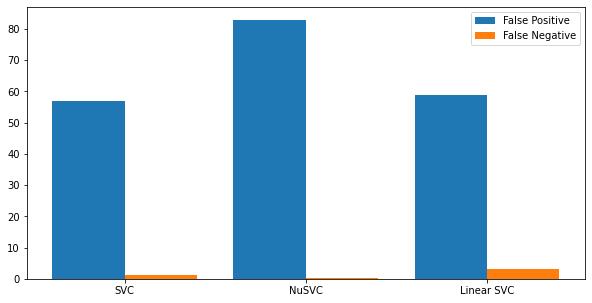

In [ ]:
modelNames=list(preds.keys())
fp=[x[0][1]/sum(x[0])*100 for x in preds.values()]
fn=[x[1][0]/sum(x[1])*100 for x in preds.values()]

xAxis=np.arange(len(modelNames))
plt.figure(figsize=(10,5))

plt.bar(xAxis -0.2, fp, width=0.4, label="False Positive")
plt.bar(xAxis +0.2, fn, width=0.4, label="False Negative")
plt.xticks(xAxis, modelNames)
plt.legend()


plt.show()

### The limit of the false negative ratio
The three SVC models seems to have high accuracy of 68%, 75%, 77% but it is caued by the unbalaced dataset. The testing dataset contains 63% positive data.
The huge difference of fase positive and false negative ratio would highly alter the accuracy of the algorithm depending on the dataset distribution.

This case shows how unreliable the accuracy can be.

Those models have the advantage of a low false negative ratio which is important since a false mositive is a pneumonia and a late diagnostic can lead to the death of the patient.

That being said, an algorithm with such a high false positive ratio (over 50% for all three models) is not practical in real life since it would require almost consistent double checks, rendering the model useless.

Therefore, different metrics need to be used. We are going to introduce cost and lifts.

### Genetic Algorithm

In [1]:
# Our cross-validation strategy (it could be just an int)
cv = StratifiedKFold(n_splits=3, shuffle=True)

param_grid = {
    'kernel': Categorical(['linear', 'rbf', 'poly', 'sigmoid', 'precomputed']),
    'gamma': Categorical([0.1, 1, 10]),
    'C': Categorical([0.1, 1, 10]),
    'degree': Categorical([1, 2, 3])
}

NameError: name 'StratifiedKFold' is not defined

In [90]:
svm.SVC().get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [91]:
GASVC = GASearchCV(
    estimator=svm.SVC(),
    cv=cv,
    scoring='accuracy',
    param_grid=param_grid,
    n_jobs=-1,
    verbose=True
)

In [92]:
GALinearSVC = GASearchCV(
    estimator= svm.LinearSVC(),
    cv=cv,
    scoring='accuracy',
    param_grid=param_grid,
    n_jobs=-1,
    verbose=True
)

In [93]:

GASVC_model = GASVC.fit(train_x, train_y)

/home/simon/.local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/simon/.local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
GALinearSVC_model = GALinearSVC.fit(train_x, train_y)

Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	50    	[ 0.776453  2.8       0.005483]	[ 0.031891  1.341641  0.003777]	[ 0.742715  1.        0.000285]	[ 0.878262  5.        0.01526 ]
1  	20    	[-1799.34227    138.06      1800.005931]	[ 3842.182703   363.382135  3841.871763]	[-10000.            1.            0.000285]	[     0.878262   1178.        10000.      ]
2  	26    	[-2999.42439    296.42      3000.005671]	[ 4582.95252    493.149798  4582.571982]	[-10000.            2.            0.001427]	[     0.878262   1163.        10000.      ]
3  	34    	[-3799.486764   293.16      3800.004914]	[ 4854.266243   473.993855  4853.860593]	[-10000.            1.            0.001427]	[     0.878262   1177.        10000.      ]
4  	17    	[-2799.390682   209.28      2800.006256]	[ 4490.368841   437.07789   4489.984963]	[-10000.            3.            0.001427]

In [ ]:
# Best parameters found
print(GASVC_model.best_params_)
# Use the model fitted with the best parameters
y_predict_ga = GASVC_model.predict(test_x)
print(accuracy_score(test_y, y_predict_ga))

In [ ]:
# Best parameters found
print(GALinearSVC_model.best_params_)
# Use the model fitted with the best parameters
y_predict_ga = GALinearSVC_model.predict(test_x)
print(accuracy_score(test_y, y_predict_ga))

In [ ]:
GA_SVC_score = GASVC_model.score(test_x, test_y)
print('SVC score: %f' % GA_SVC_score)

SVC score: 0.681090


In [ ]:
GA_LinearSVC_score = GALinearSVC_model.score(test_x, test_y)
print('SVC score: %f' % GA_LinearSVC_score)

SVC score: 0.681090


In [ ]:
GA_SVC_y_pred = GASVC_model.predict(test_x)

In [ ]:
GA_LinearSVC_y_pred = GALinearSVC_model.predict(test_x)

In [ ]:
SVCbCm = confusion_matrix(test_y, SVC_y_pred)
GASVCCm = confusion_matrix(test_y, GA_SVC_y_pred)
linearSVCbCm = confusion_matrix(test_y, linearSVC_y_pred)
GAlinearSVCbCm = confusion_matrix(test_y, GA_LinearSVC_y_pred)

predsGA = {
    "SVC": SVCbCm,
    "GA SVC": GASVCCm,
    "Linear SVC": linearSVCbCm,
    "GA Linear SVC": GAlinearSVCbCm
}

for key, value in predsGA.items():
    analyzeConfusionMatrix(key, value)

SVC falsely detected  56.84 % of sane patients as having pneumonia
SVC  killed  1.28 % of the ill patients

GA SVC falsely detected  74.79 % of sane patients as having pneumonia
GA SVC  killed  6.15 % of the ill patients

Linear SVC falsely detected  58.97 % of sane patients as having pneumonia
Linear SVC  killed  3.08 % of the ill patients

GA Linear SVC falsely detected  74.79 % of sane patients as having pneumonia
GA Linear SVC  killed  6.15 % of the ill patients



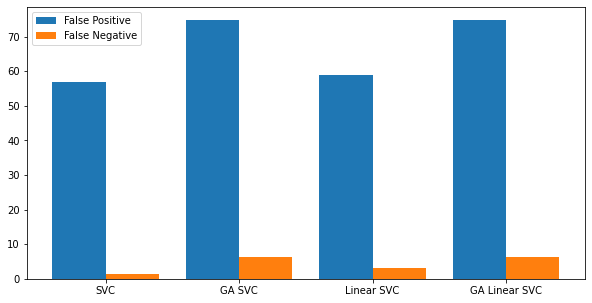

In [ ]:
modelNames=list(predsGA.keys())
fp=[x[0][1]/sum(x[0])*100 for x in predsGA.values()]
fn=[x[1][0]/sum(x[1])*100 for x in predsGA.values()]

xAxis=np.arange(len(modelNames))
plt.figure(figsize=(10,5))

plt.bar(xAxis -0.2, fp, width=0.4, label="False Positive")
plt.bar(xAxis +0.2, fn, width=0.4, label="False Negative")
plt.xticks(xAxis, modelNames)
plt.legend()


plt.show()

#### Genetic degeneration
The genetic algorithm implemented did not succeed in reducing the noise in a meaningfull way and even reduced the model effectiveness in both positive and negative case detection.